# Reference: 
Article: https://towardsdatascience.com/cryptocurrency-price-prediction-using-lstms-tensorflow-for-hackers-part-iii-264fcdbccd3f

Code: https://colab.research.google.com/drive/1wWvtA5RC6-is6J8W86wzK52Knr3N1Xbm#scrollTo=Lui1XTi0xVsF


In [148]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import LSTM

#from tensorflow.python.keras.layers import CuDNNLSTM
#from tensorflow.keras.models import Sequential

In [149]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [150]:
url_binance_bnbusdt_5m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=5m"
df = pd.read_json(url_binance_bnbusdt_5m)

df.columns = [
    'time', 
    'open', 
    'high', 
    'low', 
    'close', 
    'volume', 
    'close_time', 
    'quote_asset_volume', 
    'number_of_trades', 
    'taker_buy_base_asset_volume', 
    'taker_buy_quote_asset_volume', 
    'unused'
]

df['date'] = pd.to_datetime(df['time'], unit='ms')

df.head()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,unused,date
0,1666562700000,275.8,276.0,275.4,275.7,1319.361,1666562999999,363808.3416,671,729.105,201079.5090,0,2022-10-23 22:05:00
1,1666563000000,275.7,276.1,275.7,276.0,833.459,1666563299999,229959.4299,503,380.697,105031.5514,0,2022-10-23 22:10:00
2,1666563300000,276.0,276.1,275.8,276.0,584.709,1666563599999,161346.1053,479,144.275,39817.0567,0,2022-10-23 22:15:00
3,1666563600000,276.0,276.4,275.9,276.0,703.302,1666563899999,194225.3430,571,388.694,107332.0314,0,2022-10-23 22:20:00
4,1666563900000,276.1,276.6,276.0,276.4,896.047,1666564199999,247627.2501,601,504.912,139543.5567,0,2022-10-23 22:25:00


In [151]:
df.sort_values('time', inplace=True)

In [152]:
df.head()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,unused,date
0,1666562700000,275.8,276.0,275.4,275.7,1319.361,1666562999999,363808.3416,671,729.105,201079.5090,0,2022-10-23 22:05:00
1,1666563000000,275.7,276.1,275.7,276.0,833.459,1666563299999,229959.4299,503,380.697,105031.5514,0,2022-10-23 22:10:00
2,1666563300000,276.0,276.1,275.8,276.0,584.709,1666563599999,161346.1053,479,144.275,39817.0567,0,2022-10-23 22:15:00
3,1666563600000,276.0,276.4,275.9,276.0,703.302,1666563899999,194225.3430,571,388.694,107332.0314,0,2022-10-23 22:20:00
4,1666563900000,276.1,276.6,276.0,276.4,896.047,1666564199999,247627.2501,601,504.912,139543.5567,0,2022-10-23 22:25:00


Text(0, 0.5, 'Close Price')

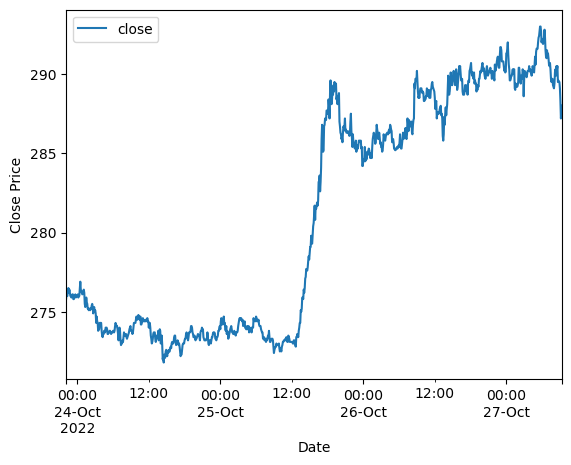

In [153]:
ax = df.plot(x='date', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")

## Normalization

In [154]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [155]:
scaled_close.shape

(1000, 1)

In [156]:
np.isnan(scaled_close).any()

False

In [157]:
scaled_close[:10], close_price[:10]

(array([[0.18396226],
        [0.19811321],
        [0.19811321],
        [0.19811321],
        [0.21698113],
        [0.22169811],
        [0.20754717],
        [0.21698113],
        [0.20754717],
        [0.19811321]]),
 array([[275.7],
        [276. ],
        [276. ],
        [276. ],
        [276.4],
        [276.5],
        [276.2],
        [276.4],
        [276.2],
        [276. ]]))

In [158]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [159]:
scaled_close = scaled_close.reshape(-1, 1)

In [160]:
np.isnan(scaled_close).any()

False

## Preprocessing

In [161]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])


    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.85)

In [162]:
X_train.shape

(765, 99, 1)

In [163]:
X_test.shape

(135, 99, 1)

## Model

In [164]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(tf.keras.layers.Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

## Training

In [165]:
model.compile(
    loss='mean_squared_error', 
    # optimizer='adam'
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [166]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/100
11/11 [==============================] - 8s 410ms/step - loss: 0.4457 - val_loss: 0.0042
Epoch 2/100
11/11 [==============================] - 3s 315ms/step - loss: 0.2070 - val_loss: 0.0836
Epoch 3/100
11/11 [==============================] - 3s 311ms/step - loss: 0.2481 - val_loss: 0.1040
Epoch 4/100
11/11 [==============================] - 3s 316ms/step - loss: 0.6325 - val_loss: 0.0329
Epoch 5/100
11/11 [==============================] - 3s 314ms/step - loss: 0.4307 - val_loss: 0.3436
Epoch 6/100
11/11 [==============================] - 3s 308ms/step - loss: 0.1064 - val_loss: 0.0501
Epoch 7/100
11/11 [==============================] - 3s 310ms/step - loss: 0.2937 - val_loss: 0.2190
Epoch 8/100
11/11 [==============================] - 3s 310ms/step - loss: 0.1801 - val_loss: 0.1594
Epoch 9/100
11/11 [==============================] - 3s 315ms/step - loss: 0.1982 - val_loss: 0.1580
Epoch 10/100
11/11 [==============================] - 3s 312ms/step - loss: 0.2051 - val_lo

In [167]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 62ms/step - loss: 0.2021


0.20210771262645721

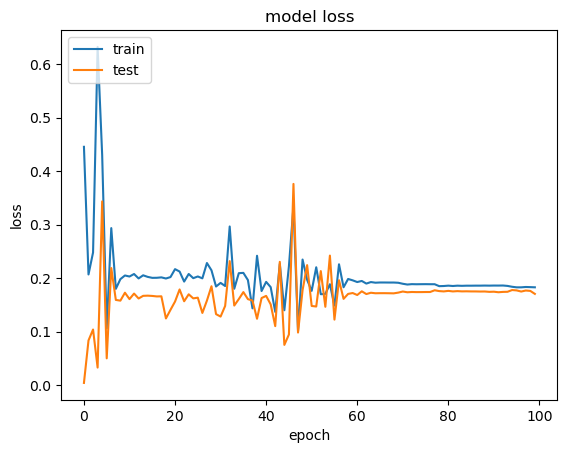

In [168]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

5/5 [==============================] - 1s 61ms/step


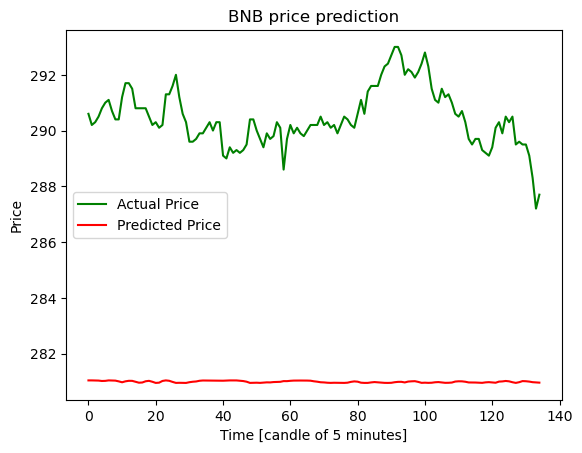

In [169]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('BNB price prediction')
plt.xlabel('Time [candle of 5 minutes]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [133]:
# Save model using the SavedModel format
!mkdir -p saved_model
model.save('saved_model/bnb-usd-prediction')

INFO:tensorflow:Assets written to: saved_model/bnb-usd-prediction/assets


INFO:tensorflow:Assets written to: saved_model/bnb-usd-prediction/assets


In [134]:
# Save model using the HDF5 format
!mkdir -p hdf5

# The '.h5' extension indicates that the model should be saved to HDF5
model.save('hdf5/bnb-usd-prediction.h5')